## set running directory to project source

In [1]:
import os
import sys
sys.path.append(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src'))

from pkg.utils.code_scraps import add_indy_sweep_tool, \
        use_current_place_point_only, use_current_sub_binders_only, \
        finish_L_shape, set_l_shape_object, ModeSwitcher, double_sweep_motions

from pkg.controller.combined_robot import *
from pkg.project_config import *
from pkg.geometry.builder.scene_builder import SceneBuilder
from pkg.planning.scene import PlanningScene
from pkg.planning.pipeline import PlanningPipeline
from pkg.ui.ui_broker import *
from pkg.planning.constraint.constraint_actor import Gripper2Tool, PlacePlane, SweepFramer, FixtureSlot
from pkg.planning.constraint.constraint_common import MotionConstraint
from pkg.planning.constraint.constraint_subject import AbstractTask, AbstractObject
from pkg.planning.constraint.constraint_subject import SweepLineTask
from pkg.planning.constraint.constraint_subject import SweepFrame
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
from pkg.planning.task.rrt import TaskRRT
from pkg.planning.constraint.constraint_common import sample_redundancy, combine_redundancy
from pkg.planning.sampling.node_sampling import make_state_param_hashable, UniformNodeSampler, PenaltyNodeSampler, GrowingSampler
from pkg.planning.task.custom_rules.sweep_entrance_control import SweepEntranceControlRule
import matplotlib.pyplot as plt
import math
import numpy as np
from collections import defaultdict
from demo_utils.area_select import DATASET_DIR, SweepDirections
try_mkdir(DATASET_DIR)

## create scene builder

In [2]:
ROBOT_TYPE = RobotType.indy7
TIMEOUT_MP = 0.5

robot_config = RobotConfig(0, ROBOT_TYPE, ((0.0,0.0,0), (0,0,0)), INDY_IP)

crob = CombinedRobot(robots_on_scene=[robot_config], connection_list=[False])

ROBOT_NAME = robot_config.get_indexed_name()
s_builder = SceneBuilder(None)
# s_builder.reset_reference_coord(ref_name="floor")

connection command:
indy0: False


## make geometry scene

In [3]:
BASE_LINK = "base_link"
EE_NAME = "ee_point"
gscene = s_builder.create_gscene(crob, start_rviz=False)

floor = gscene.create_safe(GEOTYPE.BOX, "floor", BASE_LINK, (3,3,0.01), (0,0,0), 
                           rpy=(0,0,0), color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=False)
gtems = s_builder.add_robot_geometries(color=(0,1,0,0.5), display=True, collision=True)
# ee_point.draw_traj_coords([[0]*6])

Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.


## init planning pipeline

In [4]:
pscene = PlanningScene(gscene, combined_robot=crob)
TIP_LINK = pscene.robot_chain_dict[ROBOT_NAME]["tip_link"]
ee_point = gscene.create_safe(GEOTYPE.SPHERE, EE_NAME, TIP_LINK, (0.01,)*3, 
                              center=(0,0,0), rpy=(0,0,0), 
                              color=(0.8,0.2,0.2,0.8), display=True, fixed=True, collision=False)

ppline = PlanningPipeline(pscene)

mplan = MoveitPlanner(pscene)
mplan.update_gscene()
ppline.set_motion_planner(mplan)


# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


## Set Parameters

In [5]:
ROBOT_TYPE = RobotType.indy7
TIMEOUT_MP = 0.5

# X_step = 0.1
# Y_step = 0.01
# Z_step = 0.1
X_step = 0.02
Y_step = 0.01
Z_step = 0.02

SWEEP_AXIS = "Y"

VISUALIZE = False
VERBOSE = False
N_try = 3
SWEEP_DIV = 10

# # dummy tool coord
# gscene.add_highlight_axis("tool", "coord", link_name="indy0_tcp", 
#                           center=(0.1,0,0.2), orientation_mat=Rot_rpy((0,0,np.pi)))

## Scan

In [6]:
for sweep_dir in SweepDirections:
    DATASET_PATH = os.path.join(DATASET_DIR, SweepDirections.get_file_name(ROBOT_TYPE, sweep_dir))
    R_be = SweepDirections.get_dcm_re(sweep_dir)

    if sweep_dir == SweepDirections.front:
        X_range = (0.3, 1)
        Y_range = (-1, 1)
        Z_range = (0.0, 0.7)
    elif sweep_dir == SweepDirections.up:
        X_range = (0.2, 0.8)
        Y_range = (-1, 1)
        Z_range = (0.0, 1.3)
    elif sweep_dir == SweepDirections.down:
        X_range = (0.2, 0.8)
        Y_range = (-1, 1)
        Z_range = (-0.7, 0.6)
    else:
        raise(NotImplementedError("SweepDirection not implemented"))
        
    gtimer = GlobalTimer.instance()
    gtimer.reset()

    X_DIR, Y_DIR, Z_DIR = np.identity(3, dtype=np.int)
    SWEEP_AX_IDX = "xyz".find(SWEEP_AXIS.lower())
    SWEEP_DIR = [X_DIR, Y_DIR, Z_DIR][SWEEP_AX_IDX]
    RANGE_STEPS_REF = [(X_range, X_step, X_DIR), (Y_range, Y_step, Y_DIR), (Z_range, Z_step, Z_DIR)]
    RANGE_STEPS = np.array(RANGE_STEPS_REF)[np.where(np.logical_not(SWEEP_DIR))]
    RANGE1, STEP1, DIR1 = RANGE_STEPS[0]
    RANGE2, STEP2, DIR2 = RANGE_STEPS[1]
    RANGEX, STEPX, DIRX = RANGE_STEPS_REF[SWEEP_AX_IDX]
    STEP_SWEEP = float(RANGEX[1] - RANGEX[0])/SWEEP_DIV

    range_list_dict = {}
    config_list_dict = {}
    STEPS_1 = np.round(np.arange(RANGE1[0], RANGE1[1]+STEP1, STEP1), 4)
    STEPS_2 = np.round(np.arange(RANGE2[0], RANGE2[1]+STEP2, STEP2), 4)
    STEPS_X = np.round([0] + np.arange(RANGEX[0], RANGEX[1]-1e-3, STEP_SWEEP)[1:].tolist(), 4)
    LEN_1, LEN_2 = len(STEPS_1), len(STEPS_2)
    count = 0
    LEN_ALL = LEN_1*LEN_2
    gtimer.tic("test")
    for i_p1, pos1 in enumerate(STEPS_1):
        for i_p2, pos2 in enumerate(STEPS_2):
            count += 1
            with gtimer.block("loop"):
                pos0 = np.multiply(pos1, DIR1) + np.multiply(pos2, DIR2)
                key = tuple(np.round(pos0, 4))
                print("========= {} ({}/{})=========".format(key, count, LEN_ALL))
                T_be = SE3(R_be, pos0)
                for _ in range(N_try):
                    traj, success = mplan.planner.plan_py(
                        ROBOT_NAME, TIP_LINK, np.concatenate(T2xyzquat(T_be)), BASE_LINK, np.zeros(gscene.joint_num), 
                        timeout=TIMEOUT_MP)

                    if success:
                        break
                if not success:
                    continue
                p2p_list = []
                qpair_list = []
                for i_px, posx in enumerate(STEPS_X):
                    pos_sweep = np.multiply(posx, DIRX)
                    pos = pos0 + pos_sweep
                    T_be = SE3(R_be, pos)
                    if i_px > 0: # already done for 0
                        if abs(posx) < 1e-4: # already done for 0 at 0 index
                            continue
                        traj, success = mplan.planner.plan_py(
                            ROBOT_NAME, TIP_LINK, np.concatenate(T2xyzquat(T_be)), BASE_LINK, np.zeros(gscene.joint_num), 
                            timeout=TIMEOUT_MP)
                    if not success:
                        continue
                    Q0 = traj[-1]
                    if VISUALIZE:
                        gscene.show_pose(Q0)

                    pos_tar = np.multiply(RANGEX[0], DIRX)
                    dP_tar = pos_tar - pos_sweep
                    Traj_down, success = get_sweep_traj(mplan, ee_point, dP_tar, Q0, DP=STEPX, ERROR_CUT=0.01, VISUALIZE=VISUALIZE, VERBOSE=VERBOSE)
                    if len(Traj_down)==0:
                        continue
                    Qdown = Traj_down[-1]

                    pos_tar = np.multiply(RANGEX[1], DIRX)
                    dP_tar = pos_tar - pos_sweep
                    Traj_up, success = get_sweep_traj(mplan, ee_point, dP_tar, Q0, DP=STEPX, ERROR_CUT=0.01, VISUALIZE=VISUALIZE, VERBOSE=VERBOSE)
                    if len(Traj_up)==0:
                        continue
                    Qup = Traj_up[-1]

                    p0 = ee_point.get_tf(list2dict(Q0, gscene.joint_names))[SWEEP_AX_IDX,3]
                    pdown = ee_point.get_tf(list2dict(Qdown, gscene.joint_names))[SWEEP_AX_IDX,3]
                    pup = ee_point.get_tf(list2dict(Qup, gscene.joint_names))[SWEEP_AX_IDX,3]
                    p2p = (pdown, pup)
                    qpair = (Qdown, Q0, Qup)
                    if np.multiply(*np.sign(p2p))<0:
                        p2p_list.append(p2p)
                        qpair_list.append(qpair)
                range_list_dict[key] = np.array(p2p_list)
                config_list_dict[key] = np.array(qpair_list)
        elapsed = gtimer.toc("test")/1000
        print(gtimer)
        print("=============================================")
        print("=============== {} / {} s===================".format(int(elapsed), int(elapsed/count*LEN_ALL)))

        print("=============================================")

    best_range_dict = {}
    for k,v in range_list_dict.items():
        if len(v)>0:
            i_max = np.argmax(v[:,1]-v[:,0])
            best_range_dict[k] = v[i_max]
        else:
            best_range_dict[k] = (0,0)
    np.save(DATASET_PATH, {"best_range_dict": best_range_dict, "range_list_dict": range_list_dict, "config_list_dict": config_list_dict})

========= (0.2, 0.0, -0.7) (1/2112)=========
singular
singular
singular
singular
joint min
singular
========= (0.2, 0.0, -0.68) (2/2112)=========
joint min
joint min
singular
joint max
singular
singular
========= (0.2, 0.0, -0.66) (3/2112)=========
joint max
joint max
singular
joint max
joint max
joint max
========= (0.2, 0.0, -0.64) (4/2112)=========
joint min
joint max
singular
joint max
singular
joint max
joint min
joint min
singular
singular
========= (0.2, 0.0, -0.62) (5/2112)=========
singular
joint max
singular
singular
singular
joint max
joint max
joint max
singular
singular
========= (0.2, 0.0, -0.6) (6/2112)=========
joint min
joint min
error off
joint max
joint max
joint max
joint min
joint min
singular
singular
========= (0.2, 0.0, -0.58) (7/2112)=========
singular
singular
singular
singular
singular
joint max
singular
singular
singular
singular
========= (0.2, 0.0, -0.56) (8/2112)=========
joint min
joint max
singular
singular
singular
joint max
joint max
joint max
joint m

IndexError: string index out of range

In [ ]:
# np.save(DATASET_PATH, {"best_range_dict": best_range_dict, "range_list_dict": range_list_dict, "config_list_dict": config_list_dict})

## plot ranges

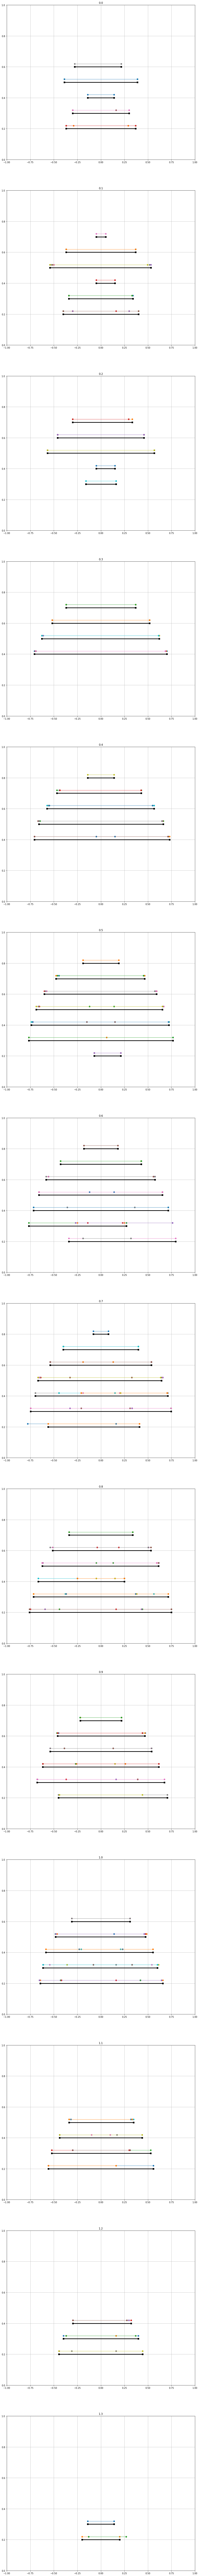

In [8]:
plt.figure(figsize=(15,15*LEN_2))
for i_h, height_plot in enumerate(STEPS_2):
    plt.subplot(LEN_2, 1, i_h+1)
    plt.title(height_plot)
    for k,v in range_list_dict.items():
        if round(k[2], 4)==round(height_plot, 4):
            for vv in v:
                plt.plot(vv, [k[0]+0.02, k[0]+0.02], '-o', linewidth=1)
            plt.plot(best_range_dict[k], [k[0], k[0]], '-ks', linewidth=3)
    plt.axis([-1,1,0,1])
    plt.grid()

## Read and save min/max csv

In [12]:
for sweep_dir in SweepDirections:
    DIRECTION = "-"+sweep_dir.name
    filename = SweepDirections.get_file_name(ROBOT_TYPE, sweep_dir)
    DATASET_PATH = os.path.join(DATASET_DIR, filename+".npy")
    dataset_read = np.reshape(np.load(DATASET_PATH, allow_pickle=True), (1,))[0]
    range_list_dict = dataset_read['range_list_dict']
    best_range_dict = dataset_read['best_range_dict']
    
    SWEEP_VEC = [0,1,0]
    min_points = []
    max_points = []
    for k,v in best_range_dict.items():
        min_points.append(tuple(np.add(k, np.multiply(v[0], SWEEP_VEC))))
        max_points.append(tuple(np.add(k, np.multiply(v[1], SWEEP_VEC))))
    min_points = sorted(min_points, key=lambda x: (x[2], x[0], x[1]))
    max_points = sorted(max_points, key=lambda x: (x[2], x[0], x[1]))
    np.savetxt(os.path.join(DATASET_DIR, filename+'-min.csv'), min_points, delimiter=",")
    np.savetxt(os.path.join(DATASET_DIR, filename+'-max.csv'), max_points, delimiter=",")

In [16]:
# DATASET_PATH_BAK1 = os.path.join(DATASET_DIR+"_bak", ROBOT_TYPE.name+'-up.npy')
# DATASET_PATH_BAK2 = os.path.join(DATASET_DIR+"_bak2", ROBOT_TYPE.name+'-up.npy')
# dataset_read_bak1 = np.reshape(np.load(DATASET_PATH_BAK1, allow_pickle=True), (1,))[0]
# dataset_read_bak2 = np.reshape(np.load(DATASET_PATH_BAK2, allow_pickle=True), (1,))[0]
# for k, v in dataset_read_bak1.items():
#     v.update(dataset_read_bak2[k])
# np.save(DATASET_PATH, dataset_read_bak1)